EX06PR : 뉴스기사 요약해보기

In [ ]:
!pip install summa
#컴퓨팅 87.55 81.97 2차 9:10 시작 10:20 로컬 연결 다시 초기화

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=c4dca98989adc57298aae1b3f43ca81777fb303e77496ac24b78a1a2cea14fe3
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.17.1
2.2.2
1.2.0


In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


Step 1. 데이터 수집하기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import urllib.request
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/News_Summary-master/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data['Summary']=data['headlines']
data['Text']=data['text']

In [ ]:
data.drop(['headlines','text'],axis=1,inplace=True)

In [ ]:
data.sample(10)

,Summary,Text
70496,Couple who 'pranked' their children sentenced ...,"An American couple who posted ""prank"" videos w..."
15175,"Govt takes control of IL&FS, Uday Kotak to be ...",The National Company Law Tribunal has allowed ...
9466,Maha CM shouldn't fear PM over Shivaji statue ...,The Shiv Sena on Monday said CM Devendra Fadna...
52153,Rocket lands in Indian embassy premises in Kabul,A rocket landed in the premises of the Indian ...
62393,Insolvency action on firm for not paying worke...,The National Company Law Tribunal has admitted...
63579,Pak beat SL as they host team for 1st time sin...,"Pakistan defeated Sri Lanka on home soil, whil..."
85525,US launches warship in name of shooting survivor,The US Navy on Saturday commissioned a new war...
69407,Child sexual abuse cases in Karnataka to be fa...,Karnataka High Court Chief Justice SK Mukherje...
27782,"Steyn names Sachin, Sehwag in his all-time bes...",South African pacer Dale Steyn has included In...
22547,"NRC is my baby, PM Modi only foster father: Fo...",Former Assam Chief Minister Tarun Gogoi has sa...


- 학습노드의 코드를 편하게 사용하기 위해, 헤드라인 -> 서머리로 타이틀을 변경하였습니다

Step 2. 데이터 전처리하기 (추상적 요약)


In [ ]:
print('Text 열에서 중복을 배제하기 전 샘플의 수 :', len(data['Text']))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())
# 큰 차이 없다

Text 열에서 중복을 배제하기 전 샘플의 수 : 98401
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
data.drop_duplicates(subset = ['Text'], inplace=True) # 중복을 제거시켜주는 함수 drop_duplicates
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print('null값 확인 :', data.isnull().sum())

null값 확인 : Summary    0
Text       0
dtype: int64


In [ ]:
# 텍스트 정규화와 불용어 제거
"""살아남은 88,425개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.
예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.
이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 해요.
여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요."""

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))



정규화 사전의 수:  120


In [ ]:
"""하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요.
이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요.
여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요."""
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))
"""NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요.
이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.
함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요.
Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다.!
이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요."""

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    """	1.	sentence.split(" "):
	•	입력 텍스트를 공백을 기준으로 단어 단위로 나눕니다.
	•	예: "don't stop" → ['don\'t', 'stop']
  •	약어(t)가 사전(contractions)에 존재하면 해당 단어를 변환합니다.
	•	예: "don't" → "do not", "can't" → "cannot"
	•	약어가 없는 단어는 그대로 유지됩니다.
	•	예: "stop" → "stop"

	3.	' '.join([...]):
	•	변환된 단어들을 다시 공백으로 연결해 완성된 문장을 생성합니다.
	•	예:
	•	입력: "don't stop"
	•	출력: "do not stop"
    """

    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text에서만)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary에서는)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    """
    1.	sentence.split():
  	•	텍스트를 공백을 기준으로 단어 단위로 나눕니다.
  	•	예: "this is a simple example" → ['this', 'is', 'a', 'simple', 'example']
  	2.	if not word in stopwords.words('english'):
  	•	단어가 NLTK의 영어 불용어 리스트(stopwords.words('english'))에 속하지 않을 경우에만 선택합니다.
  	•	불용어 예시: "a", "the", "is" 등이 포함됩니다.
  	•	예: "this is a simple example" → ['simple', 'example']
  	3.	if len(word) > 1:
  	•	단어 길이가 2 이상인 단어만 선택합니다.
  	•	단문자 단어는 제거됩니다.
  	•	예: ['simple', 'example', 'x'] → ['simple', 'example']
  	4.	' '.join([...]):
  	•	필터링된 단어들을 공백으로 연결해 최종 텍스트를 반환합니다.
  	•	예: "this is a simple example" → "simple example"
    """
    return tokens # 전처리가 끝난 텍스트를 반환합니다.
print('=3')



불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# [[YOUR CODE]]
# Series의 각 요소에 대해 preprocess_sentence 함수를 적용
clean_text = data['Text'].apply(preprocess_sentence)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

# 전처리된 Summary 데이터를 저장할 리스트
clean_summary = []

# Summary 열 데이터를 반복문으로 전처리 (불용어 제거 X)
for summary in data['Summary']:
    clean_summary.append(preprocess_sentence(summary, remove_stopwords=False))

# 결과 확인
print(clean_summary[:5])

Text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: Text, dtype: object


<ipython-input-13-04d175f6a2e0>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 중간회고 : 추후 작업 수정을 위해, 파일 저장 경로 생성
- 위 파일 저장 경로가 잘못되어 저장이 안됨. (같은 조원 서영님의 numpy변경 전 토큰화까지 된 csv파일로 이후 진행완료)
- 최종회고 : 무슨 이유인지 모르겠지만, 토큰화된 csv파일을 받아오면 최종 요약문 비교에서 에러가 났습니다. 따라서 다시 clean data 전처리를 시도한 뒤 프로젝트를 다시금 진행하였습니다.

In [ ]:
import pandas as pd

# 전처리된 데이터를 새로운 데이터프레임으로 생성
processed_data = pd.DataFrame({
    'clean_text': clean_text,
    'clean_summary': clean_summary
})

# Google Drive 내 특정 경로에 저장 csv파일로
processed_data.to_csv('/content/drive/My Drive/clean_data_textsumm.csv', index=False, encoding='utf-8')
print("전처리된 데이터가 Google Drive의 'My Drive/processed_data.csv' 파일로 저장되었습니다.")

# # 불러오기
# # CSV 파일 읽기
# loaded_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/token_data.csv', encoding='utf-8')

# # 결과 확인
# print("저장된 데이터 로드 완료!")
# loaded_data.head()

전처리된 데이터가 Google Drive의 'My Drive/processed_data.csv' 파일로 저장되었습니다.


- 하단, 10분 이상씩 소요

In [ ]:
data['Text'] = clean_text
data['Summary'] = clean_summary

- 디버깅 : 1차 프로젝트를 할때, 위부분의 코드를 실행시키지 않아도 된다고 생각했는데, 실행하지 않을시 하단의 max_len 및 평균값에 큰 차이가 났습니다.
- 왜 그럴까,, 이후 좀더 알아보겠습니다.

In [ ]:
data.replace('', np.nan, inplace=True)
print('=3')
print('null갑 확인: ', data.isnull().sum())

=3
null갑 확인:  Summary    0
Text       0
dtype: int64


In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534
텍스트의 표준편차 : 3.7993861876499637
요약 표준편차: 1.3900944321771693
text_maxlen  :  42
summ_maxlen  :  12


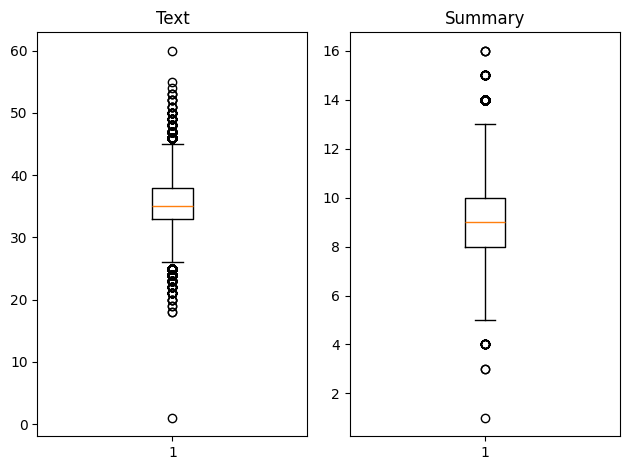

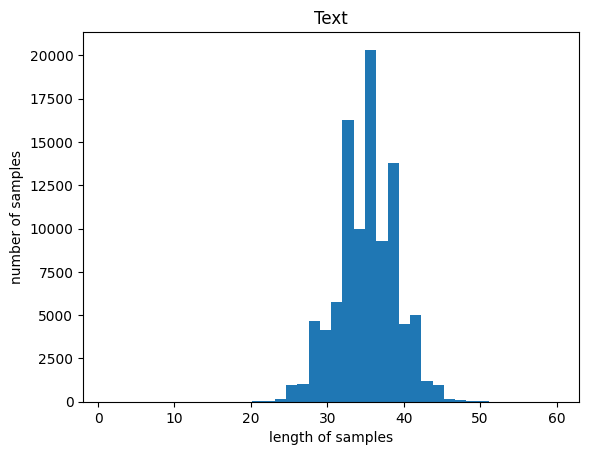

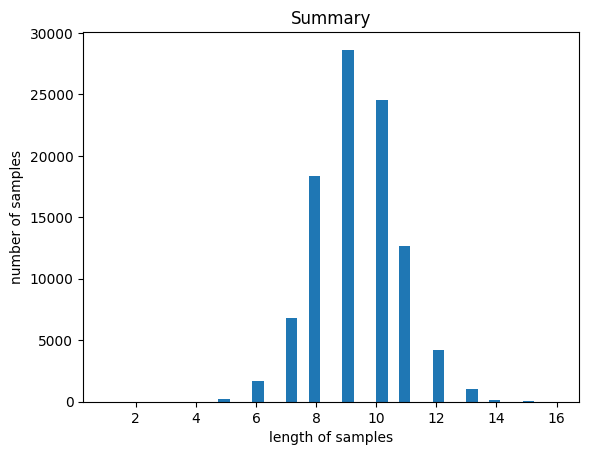

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

print('텍스트의 표준편차 : {}'.format(np.std(text_len)))
print('요약 표준편차: {}'.format(np.std(summary_len)))

# 텍스트와 요약 각각에 대해 maxlen 설정
text_max_tokens = np.mean(text_len) + 2 * np.std(text_len)  # 평균 + 2 * 표준편차
summary_max_tokens = np.mean(summary_len) + 2 * np.std(summary_len)

# 길이를 정수로 변환
text_maxlen = int(text_max_tokens)
summary_maxlen = int(summary_max_tokens)

print('text_maxlen  : ', text_maxlen)
print('summ_maxlen  : ', summary_maxlen)


plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 중간회고 : 실제 평균 표준편차를 이용하여, max_len을 구하였지만,  
2차시도에는 토큰작업까지 이뤄진 서영님 자료를 활용. 하단 넘파이 변경 이후 수정을 이어갔습니다.
- 최종회고 : 다시 프로젝트를 처음부터 돌려, 평균과 표준편차를 활용한 max_len을 활용하였습니다.

In [ ]:
# 이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.
text_max_len = text_maxlen
summary_max_len = summary_maxlen
print('=3')

=3


Threshold 설정 및 max_len길이보다 큰 샘플 제외하기

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [ ]:
#이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [ ]:
# 조건에 맞지 않는 샘플 제거 Text 60, summary 8 기준 초과는 삭제
data = data[
    (data['Text'].apply(lambda x: len(x.split())) <= text_max_len) &
    (data['Summary'].apply(lambda x: len(x.split())) <= summary_max_len)
]

# 결과 확인
print(f"Filtered data shape: {data.shape}")

Filtered data shape: (94754, 2)


시작토큰, 종료토큰 추가

In [ ]:
# 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

# 요약Summary 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x) # sos토큰을 맨앞에, 모든 열에 추가
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken') # eos토큰을 맨뒤에
data.sample(10)

,Summary,Text,decoder_input,decoder_target
97206,germany to clear gays convicted under nazi era...,german government approved bill overturn convi...,sostoken germany to clear gays convicted under...,germany to clear gays convicted under nazi era...
41958,mumbai police seizes crude bombs arrests from ...,mumbai police seized low intensity crude bombs...,sostoken mumbai police seizes crude bombs arre...,mumbai police seizes crude bombs arrests from ...
52418,china ends india monopoly on internet services...,nepal friday opened new optical fibre link chi...,sostoken china ends india monopoly on internet...,china ends india monopoly on internet services...
88401,rotten system needs to be changed rajinikanth ...,amid speculation joining politics superstar ra...,sostoken rotten system needs to be changed raj...,rotten system needs to be changed rajinikanth ...
76444,indian wins silver at world para athletics cha...,india junior para athlete rinku hooda silver m...,sostoken indian wins silver at world para athl...,indian wins silver at world para athletics cha...
32161,mural in us school depicts trump severed head ...,mural school california depicted us president ...,sostoken mural in us school depicts trump seve...,mural in us school depicts trump severed head ...
75028,concerns about earnings growth ominous sign ba...,bank america said money managers showing conce...,sostoken concerns about earnings growth ominou...,concerns about earnings growth ominous sign ba...
95465,man gets life in jail for killing person over ...,american man sentenced life prison choked man ...,sostoken man gets life in jail for killing per...,man gets life in jail for killing person over ...
65839,pained by communal angle given to firecracker ...,supreme court friday refused modify ban order ...,sostoken pained by communal angle given to fir...,pained by communal angle given to firecracker ...
65648,security researcher accused of sexual harassment,security researcher activist morgan marquis bo...,sostoken security researcher accused of sexual...,security researcher accused of sexual harassme...


In [ ]:
# 앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


Train, Validation data 분리

In [ ]:
indices = np.arange(encoder_input.shape[0]) # 인코더 인풋 데이터 수만큼 인덱스 생성
np.random.shuffle(indices) # 인덱스를 무작위로 섞어 데이터 순서 랜덤화
print(indices)

[80067 39456 20323 ... 91618 45499 24503]


In [ ]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.
#전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


단어 집합(vocabulary) 만들기 및 정수 인코딩  
"""이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요.
그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.
등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요."""

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 각단어 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 67788
등장 빈도가 6번 이하인 희귀 단어의 수: 46119
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21669
단어 집합에서 희귀 단어의 비율: 68.03416533899805
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5470809333480062


In [ ]:
src_vocab = 21500 # 단어 집합 크기 제한 (Tokenizer(num_words=src_vocab)),
                 # src_vocab을 9,000으로 설정하면, 빈도 순위 상위 21,5000개의 단어만 단어 집합에 포함됩니다.
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성, 등장 빈도가 낮아 순위에서 밀린 희귀 단어들은 자동으로 단어 집합에서 제외됩니다.
print('=3')

=3


In [ ]:
"""texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요."""
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2169, 3606, 4241, 2585, 62, 18, 312, 1384, 51, 692, 136, 308, 1384, 9778, 2169, 749, 17, 183, 312, 4701, 1384, 105, 312, 4701, 1384, 9400, 62, 18, 62, 18], [1512, 865, 372, 302, 4392, 429, 15, 1676, 4439, 1076, 26, 498, 435, 57, 376, 817, 2522, 2385, 2047, 26, 9, 781, 11558, 740, 282, 603, 435, 24, 494, 1134, 388, 412, 10003, 412, 4880, 2047, 2011, 861], [26, 83, 1189, 907, 988, 1227, 211, 199, 41, 3287, 102, 1418, 26, 46, 431, 9779, 1676, 988, 1, 47, 7, 616, 26, 9, 5179, 468, 3288, 60, 6, 13471, 3287, 17, 36, 15013, 1430, 455]]


In [ ]:
# Summary 데이터에 대해서도 동일한 작업을 수행
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [ ]:
"""이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요.
이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데,
이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요."""
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29558
등장 빈도가 5번 이하인 희귀 단어의 수: 19344
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10214
단어 집합에서 희귀 단어의 비율: 65.44421138101359
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.766408657774689


In [ ]:
tar_vocab = 10200
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4306, 8034, 627, 1072, 15, 123, 1573, 330], [1, 2829, 431, 4592, 72, 157, 258, 961, 1124, 600], [1, 39, 23, 76, 2073, 26, 62, 92, 853, 2422, 395], [1, 348, 2884, 2568, 85], [1, 271, 1244, 49, 7, 251, 2221, 1400, 291, 205, 36]]
target
decoder  [[4306, 8034, 627, 1072, 15, 123, 1573, 330, 2], [2829, 431, 4592, 72, 157, 258, 961, 1124, 600, 2], [39, 23, 76, 2073, 26, 62, 92, 853, 2422, 395, 2], [348, 2884, 2568, 85, 2], [271, 1244, 49, 7, 251, 2221, 1400, 291, 205, 36, 2]]


In [ ]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요.
# 이 샘플들은 모두 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
# enumerate()는 반복 가능한 객체(예: 리스트, 튜플, 문자열 등)에 대해 인덱스와 값을 동시에 반환합니다.
# -> decoder_input_train에서 각 문장(sentence)과 해당 문장의 인덱스(index)를 반환

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))



삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


패딩 : post 방식 사용

In [ ]:
"""텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요.
아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요."""
# Text maxlen 나는 60
# summary maxlen 나는 8

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

# 이제 학습에 필요한 데이터 전처리가 모두 끝났어요.


=3


- 중간 회고 : maxlen의 설정을 프로젝트 2차 수정중 낮게 설정하게 되어, 훈련데이터의 개수가 이전 시도(약 7만5천개)보다 작음을 확인할 수 있었습니다.
- 위와 같은 전처리에서부터 모델의 성능에 영향을 크게 주었음을 알게 됐습니다.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)  
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

인코더 설계

In [ ]:
# 함수형 API를 이용해서 인코더를 설계해 볼게요.
# Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 200 # 200차원으로 증가
hidden_size = 256 # LSTM의 뉴런 수, 출력 차원.

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) #입력 형태: (batch_size, text_max_len)에서 batch_size는 가변적이고 text_max_len은 고정된 시퀀스 길이입니다.

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.1)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.1)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) # LSTM 1의 출력인 encoder_output1을 입력으로 받습니다.

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.1)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)
"""	•	return_sequences=False: 모든 time step의 출력이 아닌 마지막 time step의 출력만 반환.
	•	역할:
	•	컨텍스트 벡터(Context Vector)로 사용할 마지막 출력만 반환하여 디코더에 전달.
	•	출력:
	•	encoder_output3: (batch_size, hidden_size) 크기의 텐서. 마지막 스텝의 출력. 디코더에 전달되는 컨텍스트 벡터.
	•	state_h3: 마지막 스텝의 hidden state.디코더 초기 상태로 사용.
	•	state_c3: 마지막 스텝의 cell state. 디코더 초기 상태로 사용.
  """

'인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. \nhidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. \n3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?\n'

- 주의, 어텐션 메커니즘은 return_sequences=True로 해야함을 노드 학습시 알게되어, 프로젝트에서는 True로 적용함을 주의하였습니다.
- dropout = 0.1로 변경

디코더 설계

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim) # tar_vocab: 디코더(목적어)의 단어 집합 크기.
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# 	디코더 LSTM은 한 시점에서 다음 단어를 예측하기 위해 현재 시점의 입력과 이전 시점의 정보를 활용.

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])
"""	•	인코더에서 전달된 마지막 hidden state와 cell state를 디코더 초기 상태로 사용.
	•	이를 통해 인코더에서 추출한 입력 시퀀스의 요약 정보(컨텍스트)를 디코더가 사용할 수 있음.

  •	출력:
	•	decoder_outputs: 모든 time step의 출력. (batch_size, timesteps, hidden_size).
	•	_: 디코더의 마지막 hidden state.
	•	_: 디코더의 마지막 cell state"""

'\t•\t인코더에서 전달된 마지막 hidden state와 cell state를 디코더 초기 상태로 사용.\n\t•\t이를 통해 인코더에서 추출한 입력 시퀀스의 요약 정보(컨텍스트)를 디코더가 사용할 수 있음.\n  \n  •\t출력:\n\t•\tdecoder_outputs: 모든 time step의 출력. (batch_size, timesteps, hidden_size).\n\t•\t_: 디코더의 마지막 hidden state.\n\t•\t_: 디코더의 마지막 cell state'

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)
"""•	Dense 레이어:
	•	Fully connected layer로 각 time step에서 단어 집합의 크기만큼 출력을 생성.
	•	각 출력은 단어 집합에서 특정 단어의 확률로 표현.
	•	매개변수:
	•	tar_vocab: 디코더 단어 집합의 크기.
	•	activation='softmax': 다중 클래스 분류를 위해 softmax 활성화 함수 사용.
	•	출력:
	•	decoder_softmax_outputs: (batch_size, timesteps, tar_vocab) 형태의 텐서.
	•	각 time step마다 단어 집합 내에서 특정 단어의 확률 분포를 반환."""

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)


어텐션 메커니즘 적용

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3]) #인코더 LSTM 마지막 층 output가져오기
"""	•	attn_layer는 디코더의 출력(decoder_outputs)과 인코더의 출력(encoder_outputs)을 입력받아, 디코더의 각 time step에 대한 컨텍스트 벡터를 계산합니다.
	•	계산 과정:
	1.	디코더 hidden state와 인코더 hidden state 간의 **유사도(가중치)**를 계산.
	2.	Softmax를 통해 가중치를 정규화.
	3.	인코더 hidden state의 가중합을 계산하여 컨텍스트 벡터를 생성."""


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
"""	•	Concatenate를 사용하여 디코더의 hidden state와 어텐션 컨텍스트 벡터를 연결합니다.
	•	이 연결된 벡터는 디코더의 다음 출력층으로 전달되어 예측을 수행합니다."""


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
"""	•	Dense(tar_vocab, activation='softmax'):
	•	목표 단어 집합의 크기(tar_vocab)에 맞는 출력층을 생성합니다.
	•	Softmax 활성화 함수는 각 출력 단어에 대한 확률 분포를 생성합니다.
	•	입력: 연결된 벡터 (decoder_concat_input).
	•	출력: 디코더가 다음 단어를 예측하기 위한 확률 분포."""


# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


#위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,
#어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.
"""
주요 흐름 요약

	1.	인코더:
	•	입력 텍스트를 임베딩 → LSTM → 모든 hidden state (encoder_outputs) 생성.
	2.	디코더:
	•	이전 단어(디코더 입력)를 기반으로 hidden state(decoder_outputs) 생성.
	3.	어텐션 적용:
	•	디코더 hidden state와 인코더 hidden state를 비교하여 컨텍스트 벡터 생성.
	•	컨텍스트 벡터와 디코더 hidden state를 연결하여 최종 입력 구성.
	4.	출력층:
	•	연결된 벡터를 통해 다음 단어를 예측하는 Softmax 출력 생성."""


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 42)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 42, 200)        │      4,300,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 42, 256),      │        467,968 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 42, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │      2,040,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 42, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        467,968 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 10200)    │      5,232,600 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,559,416 (51.73 MB)

 Trainable params: 13,559,416 (51.73 MB)

 Non-trainable params: 0 (0.00 B)

'\n주요 흐름 요약\n\n\t1.\t인코더:\n\t•\t입력 텍스트를 임베딩 → LSTM → 모든 hidden state (encoder_outputs) 생성.\n\t2.\t디코더:\n\t•\t이전 단어(디코더 입력)를 기반으로 hidden state(decoder_outputs) 생성.\n\t3.\t어텐션 적용:\n\t•\t디코더 hidden state와 인코더 hidden state를 비교하여 컨텍스트 벡터 생성.\n\t•\t컨텍스트 벡터와 디코더 hidden state를 연결하여 최종 입력 구성.\n\t4.\t출력층:\n\t•\t연결된 벡터를 통해 다음 단어를 예측하는 Softmax 출력 생성.'

- embedding 레이어 (None,38,200)
    - 200: 각 단어가 임베딩 벡터료 변환된 크기
    - 파라미터 : src_vocab(15,000) × embedding_dim(200) = 3,000,000.
    - Connected to: input_layer[0][0] : input_layer의 출력 텐서를 임베딩 레이어의 입력으로
- 	LSTM 레이어 Output Shape:
	  - 	[(None, 38, 256), (None, 256), (None, 256)]
	  - 	(None, 38, 256): 모든 타임스텝에서의 출력
	  - 	(None, 256): 마지막 타임스텝의 hidden state와 cell state
- Attention Layer Connected to:
	-	lstm_3[0][0] (디코더 출력).
	-	lstm_2[0][0] (인코더 출력).
	-	어텐션 메커니즘은 디코더와 인코더 출력 모두에 연결됩니다.
- 정리
	1.	인코더 임베딩 → 인코더 LSTM
	2.	디코더 임베딩 → 디코더 LSTM
	3.	인코더 출력 + 디코더 출력 → 어텐션 레이어
	4.	어텐션 결과 + 디코더 출력 → 연결 레이어
	5.	연결 레이어 → Dense (출력층)

모델 훈련

In [ ]:
# 모델 훈련
from tensorflow.keras.callbacks import ModelCheckpoint

# 최적 모델 저장 경로 설정
checkpoint_filepath1 = 'best_model1.keras'

# ModelCheckpoint 콜백 정의
mc = ModelCheckpoint(filepath=checkpoint_filepath1,  # 저장 경로
                     monitor='val_loss',           # 모니터링할 기준 지표
                     save_best_only=True,          # 최상의 모델만 저장
                     verbose=1)                    # 진행 상황 표시

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history1 = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test],
                    decoder_target_test),
                    callbacks=[mc],  # 콜백 추가
                    batch_size=256, epochs=30)

# 추후사용
                    # batch_size=256, callbacks=[es], epochs=50)

Epoch 1/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 5.5342
Epoch 1: val_loss improved from inf to 4.97262, saving model to best_model1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - loss: 5.5331 - val_loss: 4.9726
Epoch 2/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 4.8379
Epoch 2: val_loss improved from 4.97262 to 4.49843, saving model to best_model1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 87s 292ms/step - loss: 4.8372 - val_loss: 4.4984
Epoch 3/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 4.3421
Epoch 3: val_loss improved from 4.49843 to 4.20888, saving model to best_model1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 87s 293ms/step - loss: 4.3417 - val_loss: 4.2089
Epoch 4/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 3.9763
Epoch 4: val_loss improved from 4.20888 to 4.01924, saving model to best_model1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 87s 292ms/step - loss: 3.9761 - val_loss: 4.0192
Epoch 5/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 3.6947
Epo

train, val Loss 시각화

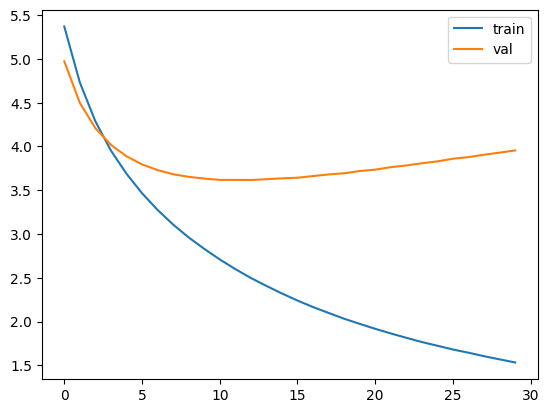

In [ ]:
# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.legend()
plt.show()

- 최종회고 : 모델 및 기록 저장은 필수!

In [ ]:
# 11.26
import pickle

# 저장 경로 설정 (구글 드라이브)
history_file_path = '/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/history2.pkl'

# history 저장
with open(history_file_path, 'wb') as f:
    pickle.dump(history1.history, f)

print(f"훈련 기록이 {history_file_path}에 저장되었습니다.")

훈련 기록이 /content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/history2.pkl에 저장되었습니다.


In [ ]:
# import pickle

# # 저장된 history 경로
# history_file_path = '/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/history1.pkl'

# # history 불러오기
# with open(history_file_path, 'rb') as f:
#     loaded_history = pickle.load(f)

# # 불러온 데이터 확인
# print("훈련 기록:", loaded_history.keys())

# # 그래프 시각화
# import matplotlib.pyplot as plt
# plt.plot(loaded_history['loss'], label='train')
# plt.plot(loaded_history['val_loss'], label='val')
# plt.legend()
# plt.show()

In [ ]:
# 모델 저장 경로
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/trained_model2.h5'

# 학습된 모델 저장
model.save(model_save_path)
print("모델이 저장되었습니다:", model_save_path)

모델이 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/trained_model2.h5


- 중간회고 : 앞으로 모델, 히스토리, 모델 체크포인트를 항상 염두하고 모델을 설계해야함을 깨닫게 되었습니다.  
   (언제든 데이터를 가공하고, 성능 개선을 할 수 있도록)

인퍼런스 모델 구현

In [ ]:
# 인퍼런스 모델 구현
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
print('=3')

=3


In [ ]:
# 어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # 예외 처리: KeyError 방지
        sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')  # 없는 경우 <UNK>로 대체

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <EOS> 또는 최대 길이 초과
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 타겟 시퀀스 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
print(tar_word_to_index['sostoken'])  # 예: 1
print(tar_word_to_index['eostoken'])  # 예: 2

1
2


In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq: # input_seq 리스트 순회
        if (i!=0):
            temp = temp + src_index_to_word[i]+' ' # src_index 사전에서 텍스트 가져온뒤 한칸 띄기
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:  # input_seq 리스트 순회
        # 0, 시작 토큰(sostoken), 종료 토큰(eostoken)은 제외
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '  # 요약문의 단어 사전 사용
    return temp.strip()  # 불필요한 공백 제거


print('=3')

=3


실제결과 요약문 비교(추상적 요약)

In [ ]:
for i in range(0, 30): #30개 확인
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : leaked audio clip john ceo whole foods acquired amazon heard saying sure amazon probably gotten disagreement person adding least amount lose said ultimately afraid get fired however disclose caused disagreement 
실제 헤드라인 : not afraid to get fired whole foods ceo on tiff with amazon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
예측 요약 :  amazon is not shy for employees says amazon ceo


원문 : number indians going abroad blue collar workers reduced around according recently released government data workers going major countries decline reportedly attributed several factors including decreasing construction business wes

- 몇개의 요약만 봐도, 기사 요약 성능이 매우 좋지 않다는 것을 확인할 수 있었습니다.
- 정량적 평가지표도 활용해서 알아볼 계획!

정량적 평가지표 활용

In [ ]:
# ROUGE 지표
# BLEU -> METEOR
# Perplexity 등이 있다고 한다.
# 추후 도전!

summa를 활용한 추출적 요약

Summa의 summarize()의 인자

>text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
Ext_summ_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/News_Summary-master/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
indices

array([80067, 39456, 20323, ..., 91618, 45499, 24503])

In [ ]:
# 요약 결과를 저장할 리스트
extracted_summaries = []

# text 열에서 추출적 요약 수행
def extract_summary(text):
    summary = summarize(text, ratio=0.5).strip()
    return summary if summary else text

Ext_summ_data['extracted_summary'] = Ext_summ_data['text'].apply(extract_summary)

# 요약 결과를 CSV로 저장
output_file = '/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/extracted_summaries.csv'
Ext_summ_data.to_csv(output_file, index=False, encoding='utf-8')
print(f"추출적 요약 결과가 '{output_file}'에 저장되었습니다.")

추출적 요약 결과가 '/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/extracted_summaries.csv'에 저장되었습니다.


In [ ]:
# 요약 추출 및 원문 비교 출력
for i in range(30):  # 처음 30개의 샘플 확인
    print(f"샘플 {i+1}")
    print("원문:", Ext_summ_data['text'].iloc[i])
    print("실제 헤드라인:", Ext_summ_data['headlines'].iloc[i])
    print("추출 요약:", Ext_summ_data['extracted_summary'].iloc[i])
    print("\n")

샘플 1
원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인: upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


샘플 2
원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인: Delhi techie wins free food from Swiggy for one year on CRED
추출 요약: Users get one CRED coin per rupee of 

- 추출적 요약또한 헤드라인과 비교하였을때 완벽히 요약되지 않음을 볼수 있었습니다.
- 하지만 추상적 요약보다는 가시적으로 핵심단어들이 요약에 많이 포함되어 있다는 느낌을 받았습니다.  
하단의 표를 통해 좀더 시각적으로 살펴보겠습니다.

추상적 요약과 추출적 요약 비교

In [71]:
sample_size = 30  # 가져올 샘플 수 설정

abstract_summaries = [
    decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    for i in range(sample_size)
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [79]:
abstract_summaries

[' amazon is not founder of firing says amazon',
 ' india to open space force for',
 ' trump is powerful greatest mission for trump security mission',
 ' pm modi will not be held in sri lanka prez',
 ' teacher accused of chopping students students slaps him in school',
 ' woman sues year old for daughter for plane for serena',
 ' kerala best state in governance than world day',
 ' inzamam once asked me to marry him to defend malik',
 ' woman sexually harassed by husband at delhi hospital',
 ' felt like shooting when was not scared ranveer on padmavati',
 ' sebi bars from directors of bn assets in pnb fraud',
 ' startup makes wheel that can detect users using fingers',
 ' padmaavat will be khilji in the party director',
 ' am not to be honest as economic secretary',
 ' door driven as less than me uber ceo',
 ' producer replaced as entire entire theatre on return',
 ' apple to unlock iphone with iphone id report',
 ' facebook will never be used to facebook head',
 ' infosys building more

In [83]:
import pandas as pd

# 3개 열을 30개 기준으로 맞춤
sample_size = 30
headlines_sample = Ext_summ_data['headlines'][:sample_size]
abstract_summaries_sample = abstract_summaries[:sample_size]
extracted_summaries_sample = Ext_summ_data['extracted_summary'][:sample_size]

# 데이터프레임 생성
comparison_df_sample = pd.DataFrame({
    'Headlines (원문)': headlines_sample,
    'Abstract Summary (추상적 요약)': abstract_summaries_sample,
    'Extracted Summary (추출적 요약)': extracted_summaries_sample
})


In [85]:
comparison_df_sample.head(30)

,Headlines (원문),Abstract Summary (추상적 요약),Extracted Summary (추출적 요약)
0,upGrad learner switches to career in ML & Al w...,amazon is not founder of firing says amazon,upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,india to open space force for,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,trump is powerful greatest mission for trump ...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,pm modi will not be held in sri lanka prez,"Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",teacher accused of chopping students students...,Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,woman sues year old for daughter for plane fo...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",kerala best state in governance than world day,India's previous lowest ODI total in New Zeala...
7,Govt directs Alok Verma to join work 1 day bef...,inzamam once asked me to marry him to defend ...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,woman sexually harassed by husband at delhi h...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",felt like shooting when was not scared ranvee...,Congress candidate Shafia Zubair won the Ramga...


- 헤드라인 원문과 비교하여 보았을때, 두 요약 모두 요약의 성능은(의미적) 떨어짐을 확인할 수 있습니다.
- 하지만 추출적 요약이, 추상적 요약보다 헤드라인의 핵심단어들을 좀 더 포함하고 있음을 확인할 수 있었습니다.
- 추후 요약모델과 관련된 평가지표를 확인하여 정량적으로 두 요약성능을 비교해보고 싶다는 생각을 하게됐습니다.

최종 회고
1. 모델 저장을 잘해야할 것 같습니다(ㅠ..)
2. 코드를 간결하게 짜는 연습을 많이 해야할 것 같습니다.
3. 텍스트 요약에 대해, 전처리과정이 모델을 설계하는 것 만큼이나 중요한 영역임을 깨닫게 됐습니다.
4. Attention 메커니즘에 대해 저번주에 이어 자세히 공부할 수 있어 좋았습니다.